In [3]:

from numpy.lib.function_base import insert
import pandas as pd
import numpy as np
from pandas.core.tools import numeric
import seaborn as sns
import matplotlib.pyplot as plt

from pandas.api.types import is_numeric_dtype

sns.set()

In [4]:

class Lookdata():
    """
    EDA tool class
    """
    import pandas as pd
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    
    
    def __init__(self,df) :
        self.df = df
        self.numeric_df = self.df[self.df.select_dtypes(include=['number']).columns.to_list()]
        self.cat_df = self.df[self.df.select_dtypes(exclude=['number']).columns.to_list()]
        
    def dtypes_df(self):
        """
        데이터프레임의 컬럼 타입 및 개수 확인
        보다 심플한 타입별 확인을 위해 사용
        """
        numeric_cols = self.df.select_dtypes(include=['number']).columns.to_list()
        cat_cols = self.df.select_dtypes(exclude=['number']).columns.to_list()
        print("*"*30)
        print(f'There are {len(numeric_cols)} numerical features:', '\n')
        print(f"Threre are {len(cat_cols)} categorical features:")
        all_cols = numeric_cols + cat_cols
        al_colname = ["numeric" if col in numeric_cols else "categorical" for col in all_cols]
        
        res = pd.DataFrame({"column": all_cols, "type": al_colname})
        
        return res.sort_values(by=['type'])
    
    def _dtypes(self):
        return pd.DataFrame(self.df.dtypes).rename(columns={0: 'dtype'})
        
    
    def _count_zeros(self,s):
        return len([f for f in s.values if f == 0])
    
    def _count_negative(self,s):
        return len([f for f in s.values if f < 0])

    
    def _compute_outlier(self,s):
        """ A private function that returns the list of outliers in a pd.Series
        :param df: pd.Series
        The column of the dataframe to be analyzed
        :return: list
        The list of outliers
        :raises: TypeError
        If the datatype of the column is not integer or float
        """

        if not is_numeric_dtype(s):
            raise TypeError("Must pass a column with numeric data type")

        df_ = sorted(s)
        q1, q3 = np.percentile(df_, [25, 75])
        iqr = q3 - q1

        lower_bound = q1 - (1.5 * iqr)
        upper_bound = q3 + (1.5 * iqr)
        outliers = [x for x in df_ if x < lower_bound or x > upper_bound]

        return outliers


    def _remove_outliers(self,s):
        """ 
        A private function that removes the outliers in a pd.Series
        """
        return s.loc[~s.isin(self._compute_outlier(s))]


    def diagnose(self):
        """
        결측값과 unique value 확인
        """
        
        df_ = self._dtypes().join(pd.DataFrame(self.df.isnull().T.sum(axis=1)).rename(columns={0: 'missing_value_cnt'}))
        df_['missing_value_ratio'] = df_['missing_value_cnt'].apply(lambda x: (x / len(self.df)) * 100)
        df_ = df_.join(pd.DataFrame(self.df.apply(pd.value_counts).T.count(axis=1)).rename(columns={0: 'unique_value_cnt'}))
        df_['unique_value_ratio'] = df_['unique_value_cnt'].apply(lambda x: (x / len(self.df)) * 100)
        
        return df_
    
    def diagnose_numeric(self):
        
        """
        cv(coefficient of variation) : std / mean
        cv는 측정단위가 다른 numeric data의 상대비교를 위해 사용
        """
        numeric_cols=self.numeric_df.columns.to_list()
        n = self._dtypes().join(self.df.describe().T, how='right')
        
        outliers = [len(self._compute_outlier(self.df[col])) for col in numeric_cols]
        n['median'] = np.array([np.median(self.df[col]) for col in numeric_cols])
        n['zeros_cnt'] = np.array([self._count_zeros(self.df[col]) for col in numeric_cols])
        n['negative_cnt'] = np.array([self._count_negative(self.df[col]) for col in numeric_cols])
        n['outliers_cnt'] = np.array(outliers)
        n['count'] = np.array([len(self.df[col]) for col in numeric_cols])
        n['coefficient of variance'] = np.array([(np.std(self.df[col]/np.mean(self.df[col]))) for col in numeric_cols])
        
        return n
    
    def diagnose_categorical(self):
        cat_cols = self.cat_df.columns.to_list()
        dfs = []
        for col in cat_cols:
            x_ = self.df[col].dropna()
            x_ = pd.Series(x_).to_frame() # convert series to dataframe
            x_['variable'] = str(col)  
            # method chaining 을 여러 줄에 걸쳐서
            x_ = x_.groupby(['variable',col]).size() \
                .to_frame() \
                .reset_index() \
                .rename(columns={col : 'levels', 0:'freq'}) 
            dfs.append(x_)
        
        try:
            dt = pd.concat([d for d in dfs])
            dt = dt.reset_index().drop('index',axis=1) 
            
            dt['count'] = self.df.shape[0]
            dt['ratio'] = dt['freq'] / dt['count'] * 100
            dt['rank'] = dt.sort_values(['freq'], ascending=False).groupby('variable').cumcount()+1
            
            return dt
            
            
        except ValueError as v:
            if len(cat_cols) == 0:
                raise Exception("There are no categorical variables in the dataframe")
            else:
                raise Exception(v)
        
    def glimpse(self, maxvals=10, maxlen=110):
        """
        데이터 프레임의 구조확인. dplyr 의 glimpes와 같은 기능
        """
        print('Shape: ', self.df.shape)
    
        def pad(y):
            max_len = max([len(x) for x in y])
            return [x.ljust(max_len) for x in y]
    
        # Column Name
        toprnt = pad(self.df.columns.tolist())
    
        # Column Type
        toprnt = pad([toprnt[i] + ' ' + str(self.df.iloc[:,i].dtype) for i in range(self.df.shape[1])])
    
        # Num NAs
        num_nas = [self.df.iloc[:,i].isnull().sum() for i in range(self.df.shape[1])]
        num_nas_ratio = [int(round(x*100/self.df.shape[0])) for x in num_nas]
        num_nas_str = [str(x) + ' (' + str(y) + '%)' for x,y in zip(num_nas, num_nas_ratio)]
        max_len = max([len(x) for x in num_nas_str])
        num_nas_str = [x.rjust(max_len) for x in num_nas_str]
        toprnt = [x + ' ' + y + ' NAs' for x,y in zip(toprnt, num_nas_str)]
    
        # Separator
        toprnt = [x + ' : ' for x in toprnt]
    
        # Values
        toprnt = [toprnt[i] + ', '.join([str(y) for y in df.iloc[:min([maxvals,self.df.shape[0]]), i]]) for i in range(self.df.shape[1])]
    
        # Trim to maxlen
        toprnt = [x[:min(maxlen, len(x))] for x in toprnt]
    
        for x in toprnt:
            print(x)
        
        
    
    """
    def diagnose_outliers(df: pd.DataFrame) -> pd.DataFrame:
    num_cols = [f for f in df.columns if 'int' in str(df[f].dtype) or 'float' in str(df[f].dtype)]
    q = df[num_cols].count().to_frame().drop(0, axis=1)
    outliers = [_compute_outlier(df[f]) for f in num_cols]

    q['outliers_cnt'] = [len(x) for x in outliers]
    q['outliers_ratio'] = q['outliers_cnt'].apply(lambda x: (int(x) / len(df)) * 100)
    q['outliers_mean'] = [np.mean(x) for x in outliers]
    q['with_outliers_mean'] = [np.mean(df[f]) for f in num_cols]
    q['without_outliers_mean'] = [np.mean([x for x in zip(_remove_outliers(df[f]))]) for f in num_cols]
    q['rate'] = q['outliers_mean'] / q['with_outliers_mean']
    return q
    """
    
    def diagnose_outliers(self):
        
        numeric_cols = [f for f in self.df.columns if 'int' in str(self.df[f].dtype) or 'float' in str(self.df[f].dtype)]
        q = self.df[numeric_cols].count().to_frame().drop(0, axis=1)
        outliers = [self._compute_outlier(self.df[f]) for f in numeric_cols]
        
        q['outliers_cnt'] = [len(x) for x in outliers]
        q['outliers_ratio'] = q['outliers_cnt'].apply(lambda x: (int(x) / len(self.df)) * 100)
        q['outliers_mean'] = [np.mean(x) for x in outliers]
        q['with_outliers_mean'] = [np.mean(self.df[f]) for f in numeric_cols]
        q['without_outliers_mean'] = [np.mean([x for x in zip(self._remove_outliers(self.df[f]))]) for f in numeric_cols]
        q['rate'] = q['outliers_mean'] / q['with_outliers_mean']
        
        return q

class Dataplots(Lookdata):
    
    
    def plot_outliers(self,colname):
        """
        series에서 이상치를 확인하고 이상치를 제거한 series를 반환
        """
        s=self.df[colname]
        
        try:
            f, ax = plt.subplots(2,2)
            
            sns.boxplot(s, orient='v', ax=ax[0,0]).set_title("With Outliers")
            sns.histplot(s, ax=ax[0,1]).set_title('With Outliers')
            sns.boxplot(self._remove_outliers(s), orient='v', ax=ax[1,0]).set_title("Without Outliers")
            sns.histplot(self._remove_outliers(s), ax=ax[1,1]).set_title('Without Outliers')
            f.tight_layout(w_pad=1.5,h_pad=1.0)
            

            plt.savefig(f'{s.name}.png')
        
        except ValueError as v:
            if s.dtype == 'object':
                raise Exception("This is not a numeric series")
            else:
                raise Exception(v)
            
    
    def plot_outliers_all(self):
        numeric_cols=self.numeric_df.columns.to_list()
       
        for col in numeric_cols:
           f, ax = plt.subplots(2,2)
           
           # subtitle
           f.suptitle("Outlier Analysis for {}".format(col))
           # orient 는 상자 세우기/눞히기의 차이
           sns.boxplot(self.df[col], orient='v', ax=ax[0][0]).set_title("With Outlier")
           sns.histplot(self.df[col], ax=ax[0][1]).set_title("With Outlier")
           sns.boxplot(self._remove_outliers(self.df[col]), orient='v', ax=ax[1][0]).set_title("Without Outlier")
           sns.histplot(self._remove_outliers(self.df[col]), ax=ax[1][1]).set_title("Without Outlier")
           f.tight_layout(w_pad=1.5,h_pad=1.0)
           
    plt.show()


In [5]:
df = sns.load_dataset('penguins')


In [6]:
ins = Dataplots(df)

/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_c

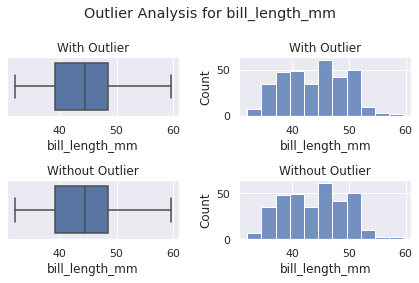

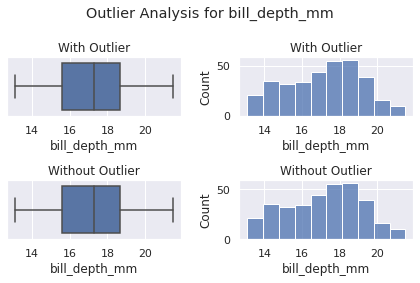

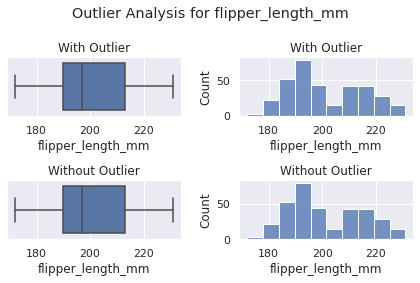

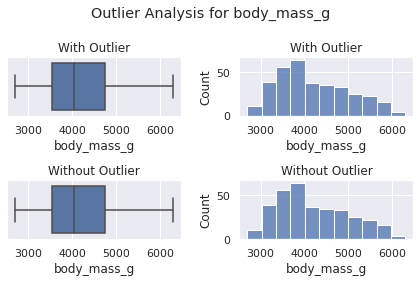

In [7]:
ins.plot_outliers_all()

Counter({0: 9900, 1: 100})
Counter({0: 1980, 1: 990})


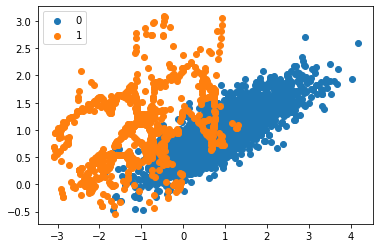

In [1]:
# Oversample with SMOTE and random undersample for imbalanced dataset
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from matplotlib import pyplot
from numpy import where
# define dataset
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.99], flip_y=0, random_state=1)
# summarize class distribution
counter = Counter(y)
print(counter)
# define pipeline
over = SMOTE(sampling_strategy=0.1)
under = RandomUnderSampler(sampling_strategy=0.5)
steps = [('o', over), ('u', under)]
pipeline = Pipeline(steps=steps)
# transform the dataset
X, y = pipeline.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1], label=str(label))
pyplot.legend()
pyplot.show()

In [3]:
y

array([0, 0, 0, ..., 1, 1, 1])

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
 
class MLplots:
    
    def __init__(self):
        pass
    
    def plot_corr_matrix(self,X,y):
        """
        X, y 에 대한 correlation matrix plot
        """
        f, ax = plt.subplots(figsize=(10,10))
        sns.heatmap(X.corr(), annot=True, linewidths=.5, fmt='.1f', ax=ax)
        plt.show()
    
    def plot_y(self,y):
        
        f, ax = plt.subplots(figsize=(10,10))
        y = pd.Series(y)
        sns.barplot(y.value_counts().index, y.value_counts().values, ax=ax)
        plt.show()


In [21]:
X, y = make_classification(n_samples=10000, n_features=2, n_redundant=0,
	n_clusters_per_class=1, weights=[0.5], flip_y=0, random_state=1)


/home/jinheonyoon/anaconda3/envs/datamind/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


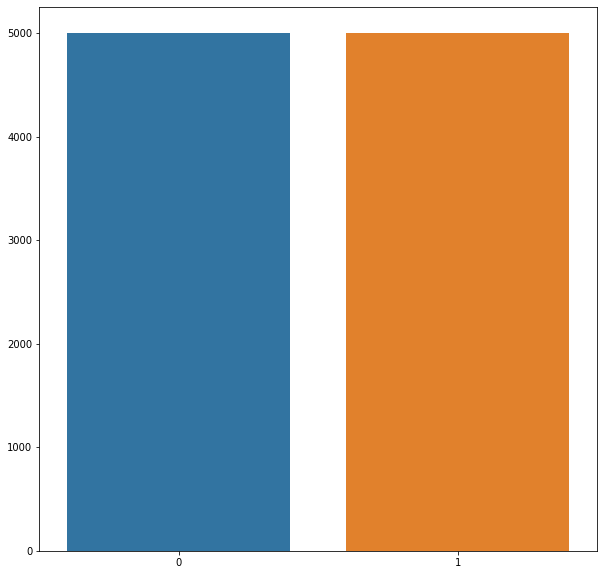

In [28]:
mm = MLplots()
mm.plot_y(y)

In [2]:
import seaborn as sns

df = sns.load_dataset('penguins')
df.select_dtypes(include=['int64','float64'])

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


In [3]:
df.select_dtypes(exclude=['int64','float64'])

,species,island,sex
0,Adelie,Torgersen,Male
1,Adelie,Torgersen,Female
2,Adelie,Torgersen,Female
3,Adelie,Torgersen,NaN
4,Adelie,Torgersen,Female
...,...,...,...
339,Gentoo,Biscoe,NaN
340,Gentoo,Biscoe,Female
341,Gentoo,Biscoe,Male
342,Gentoo,Biscoe,Female
